In [1]:
!pip install --user pandas
!pip install --user scikit-learn
!pip install --user tqdm

     |################################| 9.5MB 16.3MB/s eta 0:00:01
     |################################| 22.2MB 19.0MB/s eta 0:00:01
     |################################| 307kB 49.7MB/s eta 0:00:01


In [2]:
import onnx
import torch

In [3]:
input_size = 593      
hidden1 = 64      
hidden2 = 64
hidden3 = 64
weight_bit_width = 2
act_bit_width = 2
num_classes = 1

from brevitas.nn import QuantLinear, QuantReLU
import torch.nn as nn

model = nn.Sequential(
      QuantLinear(input_size, hidden1, bias=True, weight_bit_width=weight_bit_width),
      nn.BatchNorm1d(hidden1),
      nn.Dropout(0.5),
      QuantReLU(bit_width=act_bit_width),
      QuantLinear(hidden1, hidden2, bias=True, weight_bit_width=weight_bit_width),
      nn.BatchNorm1d(hidden2),
      nn.Dropout(0.5),
      QuantReLU(bit_width=act_bit_width),
      QuantLinear(hidden2, hidden3, bias=True, weight_bit_width=weight_bit_width),
      nn.BatchNorm1d(hidden3),
      nn.Dropout(0.5),
      QuantReLU(bit_width=act_bit_width),
      QuantLinear(hidden3, num_classes, bias=True, weight_bit_width=weight_bit_width)
)

In [4]:
import torch

trained_state_dict = torch.load("state_dict.pth")["models_state_dict"][0]


model.load_state_dict(trained_state_dict, strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
import numpy as np
from copy import deepcopy

modified_model = deepcopy(model)
W_orig = modified_model[0].weight.data.detach().numpy()
# pad the second (593-sized) dimensions with 7 zeroes at the end
W_new = np.pad(W_orig, [(0,0), (0,7)])
modified_model[0].weight.data = torch.from_numpy(W_new)

torch.Size([64, 600])

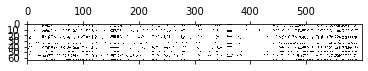

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.spy(modified_model[0].int_weight().numpy())

In [38]:
Wint = modified_model[0].int_weight().numpy()
np.count_nonzero( Wint)

3386

In [43]:
len(np.where(~Wint.any(axis=1))[0])

25

In [42]:
Wint[6]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [31]:
linear_layers = list(filter(lambda x: x.__class__.__name__ == "QuantLinear", modified_model))

In [44]:
for ll in linear_layers:
    W_current = ll.int_weight().numpy()
    print("%d of %d are nonzeros" % (np.count_nonzero(W_current), W_current.shape[0]*W_current.shape[1]))

3386 of 38400 are nonzeros
837 of 4096 are nonzeros
137 of 4096 are nonzeros
25 of 64 are nonzeros


In [25]:
W_current = modified_model[4].int_weight().numpy()
print(np.count_nonzero(W_current))
print(W_current.shape)

837
(64, 64)


In [6]:
from brevitas.core.quant import QuantType
from brevitas.nn import QuantIdentity


class CybSecMLPForExport(nn.Module):
    def __init__(self, my_pretrained_model):
        super(CybSecMLPForExport, self).__init__()
        self.pretrained = my_pretrained_model
        self.qnt_output = QuantIdentity(quant_type=QuantType.BINARY, bit_width=1, min_val=-1.0, max_val=1.0)
    
    def forward(self, x):
        # assume x contains bipolar {-1,1} elems
        # shift from {-1,1} -> {0,1} since that is the
        # input range for the trained network
        x = (x + torch.tensor([1.0])) / 2.0  
        out_original = self.pretrained(x)
        out_final = self.qnt_output(out_original)   # output as {-1,1}     
        return out_final

model_for_export = CybSecMLPForExport(modified_model)

In [7]:
import brevitas.onnx as bo

export_onnx_path = "cybsec-mlp-nids-demo.onnx"
input_shape = (1, 600)
bo.export_finn_onnx(model_for_export, input_shape, export_onnx_path)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  from ipykernel import kernelapp as app
